In [37]:
import pandas as pd
import numpy as np
import warnings
import itertools
import os
import math
from dotenv import load_dotenv
import psycopg2
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_squared_error, mean_absolute_error




In [2]:
load_dotenv(override=True)

DATABASE_URL = os.getenv("DATABASE_URL")
conn = psycopg2.connect(DATABASE_URL)
df = pd.read_sql("SELECT * FROM bed_inventory", conn)

In [3]:
df.head()

,datetime,ward,bed_type,total_beds,staffed_beds,occupied_beds,closed_beds,hospital
0,2025-03-08,HDU,HDU,11,9,6,2,hos_93421f40
1,2025-03-08,Maternity,General,13,10,8,3,hos_93421f40
2,2025-03-08,General Medicine,General,40,39,35,1,hos_5ea2c50a
3,2025-03-08,Surgery,General,40,38,33,2,hos_5ea2c50a
4,2025-03-08,Orthopaedics,General,16,14,11,2,hos_5ea2c50a


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162282 entries, 0 to 162281
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   datetime       162282 non-null  object
 1   ward           162282 non-null  object
 2   bed_type       162282 non-null  object
 3   total_beds     162282 non-null  int64 
 4   staffed_beds   162282 non-null  int64 
 5   occupied_beds  162282 non-null  int64 
 6   closed_beds    162282 non-null  int64 
 7   hospital       162282 non-null  object
dtypes: int64(4), object(4)
memory usage: 9.9+ MB


In [5]:
df.shape

(162282, 8)

In [6]:
print(df['hospital'].unique())
print(df['ward'].unique())

['hos_93421f40' 'hos_5ea2c50a' 'hos_a3d814fb' 'hos_0ba280c9'
 'hos_ed803e4f' 'hos_4b7db80d' 'hos_aadbb299' 'hos_349f8e39'
 'hos_4ccff248' 'hos_38ad1d22' 'hos_68637bd5' 'hos_7389674e'
 'hos_d33ca5af' 'hos_3bb2864c' 'hos_46e9fb57' 'hos_fbfb3b15'
 'hos_9bc4f65f' 'hos_b3d29344' 'hos_f0e9c434' 'hos_4dc5eb09'
 'hos_114e008f' 'hos_968c2059' 'hos_dc61b3bf' 'hos_75dc3992'
 'hos_407cbac6' 'hos_629cf67a' 'hos_09ac214b' 'hos_db1307f7'
 'hos_bb1586d2' 'hos_53affa52' 'hos_16a75835' 'hos_5d4a7c5b'
 'hos_6a867236' 'hos_0761b0f7' 'hos_5b1defd9' 'hos_36449bcd'
 'hos_84bce2da']
['HDU' 'Maternity' 'General Medicine' 'Surgery' 'Orthopaedics' 'ICU']


In [7]:
hospital_id = "hos_f0e9c434"
ward_name = "General Medicine"

# converting the 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

#filtering the data for a specific hospital and ward
hospital_df = df[(df['hospital'] == hospital_id)].copy()
ward_df = df[(df['ward'] == ward_name)].copy()

# sorting by datetime
ward_df = ward_df.sort_values('datetime')


print(f"Data from hospital: {hospital_id}, ward: {ward_name}")
print(f"Date range: {ward_df['datetime'].min().date()} to {ward_df['datetime'].max().date()}")

# identify missing dates and summing the no. of missing dates
# ward_df.set_index('datetime', inplace=True)
# all_dates = pd.date_range(start=ward_df.index.min(), end=ward_df.index.max(), freq='D')
# missing_dates = all_dates.difference(ward_df.index)
# print(f"Number of missing dates: {len(missing_dates)}")

print(f"No. of records: {len(ward_df)}")

print(f"Missing dates: {pd.date_range(start = ward_df['datetime'].min(), end = ward_df['datetime'].max()).difference(ward_df['datetime']).shape[0]}")

#checking for missing values in key columns
print(ward_df[['total_beds', 'occupied_beds', 'closed_beds']].isnull().sum())

ward_df.set_index('datetime', inplace=True)


Data from hospital: hos_f0e9c434, ward: General Medicine
Date range: 2024-01-01 to 2025-12-31
No. of records: 27047
Missing dates: 0
total_beds       0
occupied_beds    0
closed_beds      0
dtype: int64


In [8]:
ward_df.shape

(27047, 7)

Configuration Variables

In [9]:
# Setting parameters
FORECAST_DAYS = 14
TEST_DAYS = 28
HISTORY_DAYS = 90


Time Series created with 731 records.
Date range: 2024-01-01 to 2025-12-31
Mean occupied beds: 38.74
Standard deviation of occupied beds: 1.83


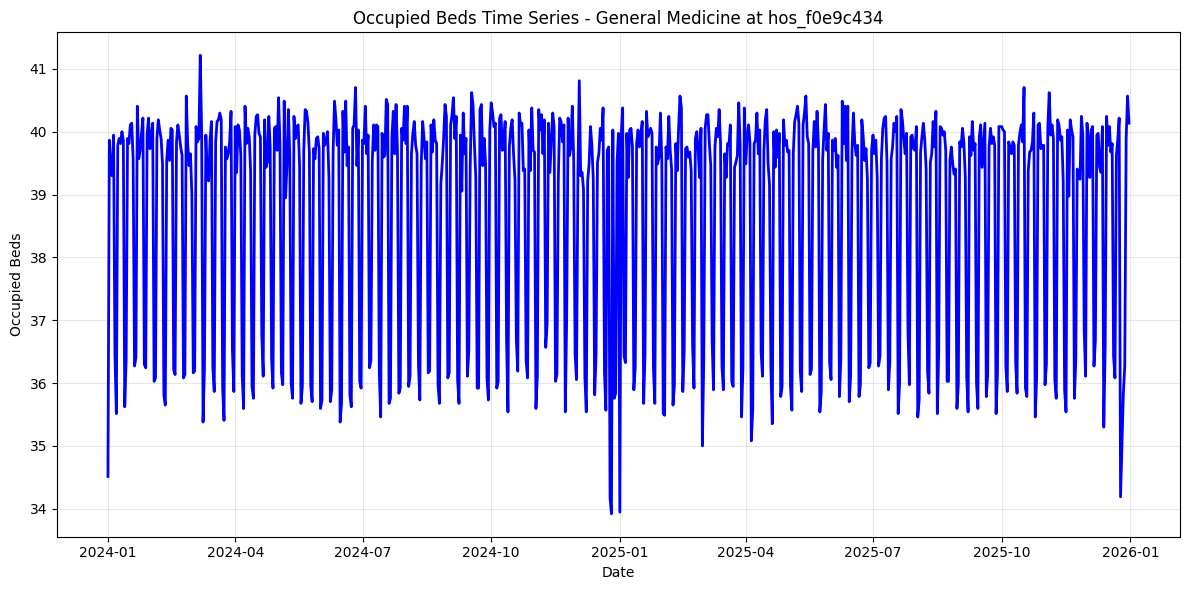

In [10]:
# resampling ward-level data to daily frequency using mean of occupied beds
ts = ward_df['occupied_beds'].resample('D').mean()

# handling missing values by forward filling and backward filling
ts = ts.ffill().bfill()

print(f"\nTime Series created with {ts.shape[0]} records.")
print(f"Date range: {ts.index.min().date()} to {ts.index.max().date()}")
print(f"Mean occupied beds: {ts.mean():.2f}")
print(f"Standard deviation of occupied beds: {ts.std():.2f}")

# plot the time series
plt.figure(figsize=(12,6))
plt.plot(ts.index, ts.values, linewidth=2, color='blue')
plt.title(f'Occupied Beds Time Series - {ward_name} at {hospital_id}')
plt.xlabel('Date')
plt.ylabel('Occupied Beds')
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

In [11]:
# spliting the data into training and testing sets
train_cutoff = ts.index.max() - pd.Timedelta(days=TEST_DAYS)
train = ts[ts.index <= train_cutoff]
test = ts[ts.index > train_cutoff]

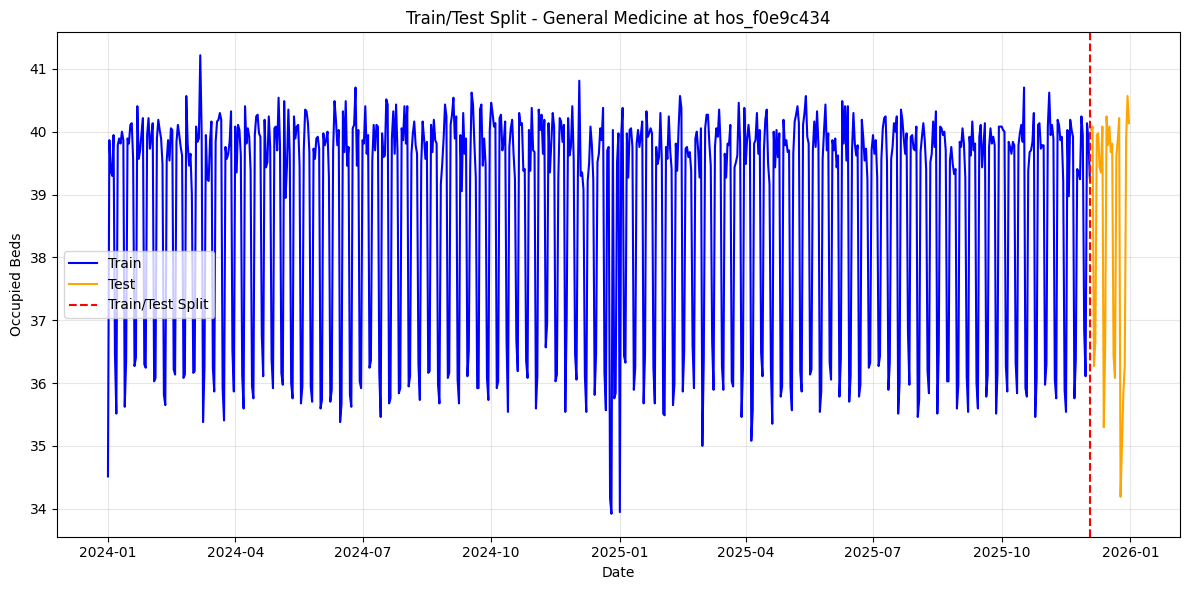

In [12]:
# visualizing the train and test sets with clear train/test split indicator
plt.figure(figsize=(12,6))
plt.plot(train.index, train.values, label='Train', color='blue')
plt.plot(test.index, test.values, label='Test', color='orange')
plt.axvline(x=train_cutoff, color='red', linestyle='--', label='Train/Test Split')
plt.title(f'Train/Test Split - {ward_name} at {hospital_id}')
plt.xlabel('Date')
plt.ylabel('Occupied Beds')
plt.legend()
plt.grid(alpha = 0.3)
plt.tight_layout()
plt.show()

In [13]:
print(f"Training SARIMA model on {ward_name} at {hospital_id}...")

# running sarima with random order for testing
ORDER = (1, 1, 1)
SEASONAL_ORDER = (1, 1, 1, 7)

#fitting the SARIMA model
model = sm.tsa.statespace.SARIMAX(
    train,
    order=ORDER,
    seasonal_order=SEASONAL_ORDER,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False, maxiter=1000)

print("Model training completed.")
print((f" AIC: {results.aic}"))
print((f" BIC: {results.bic}"))
print((f" HQIC: {results.hqic}"))

Training SARIMA model on General Medicine at hos_f0e9c434...
Model training completed.
 AIC: 1043.6886409794638
 BIC: 1066.3430291180932
 HQIC: 1052.454054315494


In [14]:
def evaluate_sarima_model(train, test, best_model_results):
    """
    Generate predictions and evaluate SARIMA model performance.
    
    Parameters:
    -----------
    train : pd.Series
        Training time series data
    test : pd.Series
        Test time series data
    best_model_results : SARIMAX results object
        Fitted SARIMA model results
    
    Returns:
    --------
    dict : Dictionary containing predictions, metrics, and forecast object
    """
    # generate predictions on test set
    test_forecast = best_model_results.get_forecast(steps=len(test))
    test_predictions = test_forecast.predicted_mean

    # calculate metrics
    mae = mean_absolute_error(test, test_predictions)
    mape = np.mean(np.abs((test - test_predictions) / test)) * 100

    # naive baseline persistence model
    naive_forecast = pd.Series([train.iloc[-1]] * len(test), index=test.index)
    naive_mape = np.mean(np.abs((test - naive_forecast) / test)) * 100

    print(f"SARIMA Model MAE: {mae:.2f} beds")
    print(f"SARIMA Model MAPE: {mape:.2f}%")
    print(f"Naive Baseline MAPE: {naive_mape:.2f}%")
    print(f"Improvement over Naive Baseline: {naive_mape - mape:.2f}%")
    
    return {
        'test_forecast': test_forecast,
        'test_predictions': test_predictions,
        'mae': mae,
        'mape': mape,
        'naive_mape': naive_mape
    }

In [15]:
# Call the function
results_dict = evaluate_sarima_model(train, test, results)
test_forecast = results_dict['test_forecast']
test_predictions = results_dict['test_predictions']

SARIMA Model MAE: 0.64 beds
SARIMA Model MAPE: 1.78%
Naive Baseline MAPE: 4.47%
Improvement over Naive Baseline: 2.70%


In [16]:
def plot_sarima_predictions(train, test, test_predictions, test_forecast, ward_name, hospital_id):
    """
    Plot SARIMA model predictions vs actuals with confidence interval.
    
    Parameters:
    -----------
    train : pd.Series
        Training time series data
    test : pd.Series
        Test time series data
    test_predictions : pd.Series
        Model predictions for test set
    test_forecast : SARIMAX forecast object
        Forecast object containing confidence intervals
    ward_name : str
        Name of the ward
    hospital_id : str
        Hospital identifier
    """
    plt.figure(figsize=(12, 6))
    plt.plot(train.index[-30:], train.values[-30:], label='Training the last 30 days', linewidth=2, color='blue')
    plt.plot(test.index, test.values, label='Actuals', linewidth=2, color='orange')
    plt.plot(test.index, test_predictions, label='SARIMA Predictions', linewidth=2, color='green')
    plt.fill_between(test.index,
                     test_forecast.conf_int()['lower occupied_beds'],
                     test_forecast.conf_int()['upper occupied_beds'],
                     alpha=0.2, label='Confidence Interval')
    plt.title(f'SARIMA Model Predictions vs Actuals - {ward_name} at {hospital_id}')
    plt.xlabel('Date')
    plt.ylabel('Occupied Beds')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

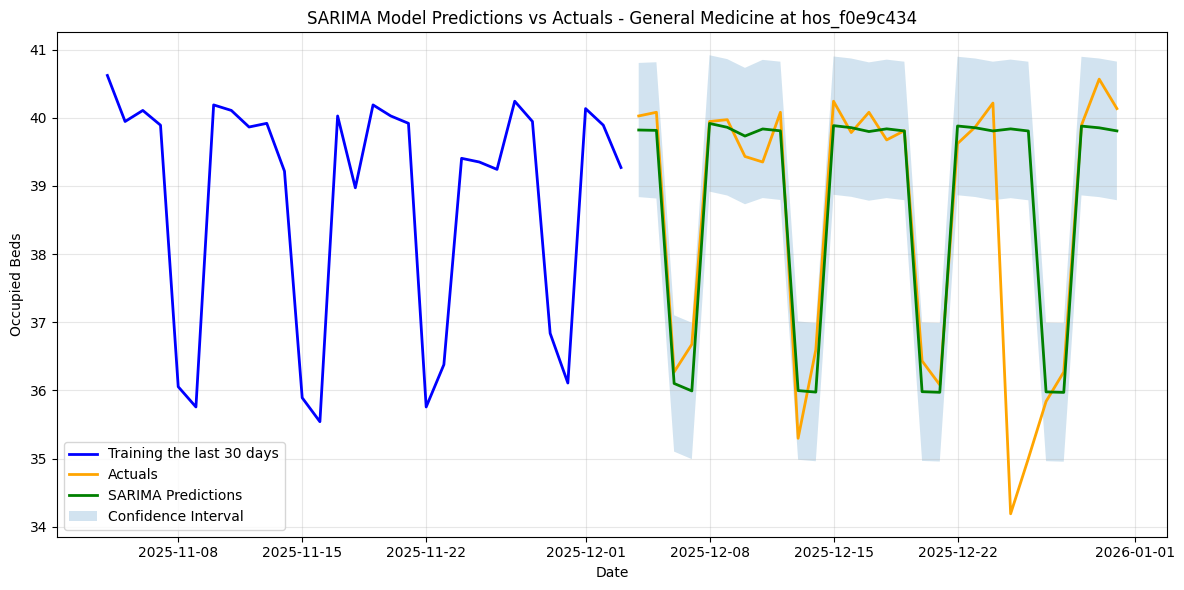

In [17]:
plot_sarima_predictions(train, test, test_predictions, test_forecast, ward_name, hospital_id)

In [18]:
# finding the best SARIMA parameters using grid search
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_params = None
best_model_results = None

for param in pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(
            train,
            order=param,
            seasonal_order=(1, 1, 1, 7),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False, maxiter=1000)
        print(f"SARIMA{param} - AIC:{results.aic:.2f} BIC:{results.bic:.2f} HQIC:{results.hqic:.2f}")
        
        # Track the best model based on AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            best_model_results = results
    except:
        continue

print(f"\nBest SARIMA Parameters: {best_params}")
print(f"Best AIC: {best_aic:.2f}")

SARIMA(0, 0, 0) - AIC:1050.35 BIC:1063.95 HQIC:1055.61
SARIMA(0, 0, 1) - AIC:1031.10 BIC:1049.23 HQIC:1038.11
SARIMA(0, 0, 2) - AIC:1031.60 BIC:1054.25 HQIC:1040.36
SARIMA(0, 1, 0) - AIC:1395.14 BIC:1408.73 HQIC:1400.40
SARIMA(0, 1, 1) - AIC:1059.88 BIC:1078.00 HQIC:1066.89
SARIMA(0, 1, 2) - AIC:1042.23 BIC:1064.88 HQIC:1051.00
SARIMA(0, 2, 0) - AIC:2099.81 BIC:2113.41 HQIC:2105.07
SARIMA(0, 2, 1) - AIC:1406.57 BIC:1424.69 HQIC:1413.58


c:\Users\mrdan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 2, 2) - AIC:1077.20 BIC:1099.84 HQIC:1085.96
SARIMA(1, 0, 0) - AIC:1032.13 BIC:1050.26 HQIC:1039.14
SARIMA(1, 0, 1) - AIC:1032.87 BIC:1055.53 HQIC:1041.64
SARIMA(1, 0, 2) - AIC:1027.37 BIC:1054.56 HQIC:1037.89
SARIMA(1, 1, 0) - AIC:1274.64 BIC:1292.77 HQIC:1281.66
SARIMA(1, 1, 1) - AIC:1043.69 BIC:1066.34 HQIC:1052.45
SARIMA(1, 1, 2) - AIC:1044.09 BIC:1071.27 HQIC:1054.61
SARIMA(1, 2, 0) - AIC:1781.60 BIC:1799.73 HQIC:1788.62
SARIMA(1, 2, 1) - AIC:1286.68 BIC:1309.33 HQIC:1295.44
SARIMA(1, 2, 2) - AIC:1062.17 BIC:1089.34 HQIC:1072.69
SARIMA(2, 0, 0) - AIC:1032.87 BIC:1055.53 HQIC:1041.63
SARIMA(2, 0, 1) - AIC:1034.61 BIC:1061.80 HQIC:1045.13
SARIMA(2, 0, 2) - AIC:1026.66 BIC:1058.38 HQIC:1038.93
SARIMA(2, 1, 0) - AIC:1210.36 BIC:1233.01 HQIC:1219.12
SARIMA(2, 1, 1) - AIC:1045.51 BIC:1072.69 HQIC:1056.03
SARIMA(2, 1, 2) - AIC:1042.74 BIC:1074.45 HQIC:1055.01
SARIMA(2, 2, 0) - AIC:1622.53 BIC:1645.18 HQIC:1631.30
SARIMA(2, 2, 1) - AIC:1224.59 BIC:1251.77 HQIC:1235.11
SARIMA(2, 

In [19]:
def fit_model(order, seasonal_order, train_data):
    """
    Fit SARIMA model with given order and seasonal order.
    
    Parameters:
    -----------
    order : tuple
        SARIMA order (p, d, q)
    seasonal_order : tuple
        SARIMA seasonal order (P, D, Q, s)
    train_data : pd.Series
        Training time series data
    
    Returns:
    --------
    SARIMAX results object : Fitted SARIMA model results
    """
    model = sm.tsa.statespace.SARIMAX(
        train_data,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False, maxiter=1000)
    return results

In [20]:
sarima_model = fit_model(best_params, (1, 1, 1, 7), train)
results_dict = evaluate_sarima_model(train, test, sarima_model)
test_forecast = results_dict['test_forecast']
test_predictions = results_dict['test_predictions']

SARIMA Model MAE: 0.63 beds
SARIMA Model MAPE: 1.76%
Naive Baseline MAPE: 4.47%
Improvement over Naive Baseline: 2.71%


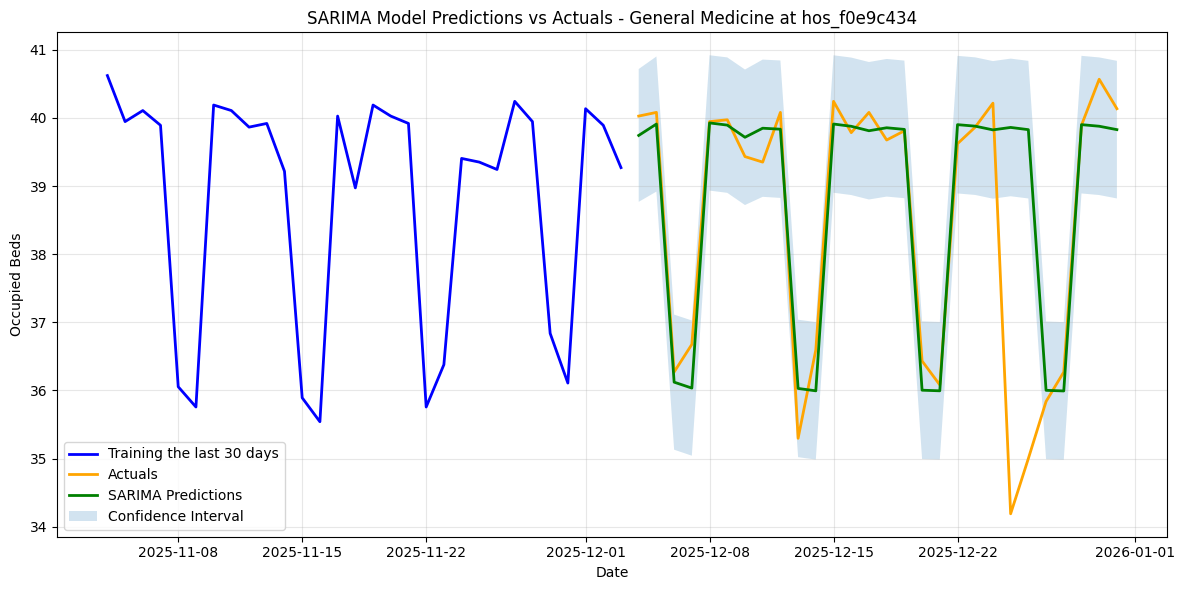

In [21]:
plot_sarima_predictions(train, test, test_predictions, test_forecast, ward_name, hospital_id)

In [22]:
# generating forecast
print(f"Generating {FORECAST_DAYS}-day forecast for {ward_name} at {hospital_id}...")

forecast = sarima_model.get_forecast(steps=FORECAST_DAYS)
forecast_df = forecast.summary_frame()

# create future dates for the forecast
forecast_dates = pd.date_range(
    start = ts.index.max() + pd.Timedelta(days=1),
    periods = FORECAST_DAYS,
    freq = 'D'
)

forecast_df.index = forecast_dates

# add metadata
forecast_df['ward'] = ward_name
forecast_df['hospital'] = hospital_id
forecast_df['date'] = forecast_df.index

# rename columns for clarity
forecast_df = forecast_df.rename(
    columns={
        'mean': 'predicted_occupied_beds',
        'mean_ci_lower': 'ci_lower',
        'mean_ci_upper': 'ci_upper'
    }
)

print(f"Forecast for the next {FORECAST_DAYS} days:")
print(f"Forcast period from {forecast_df.index.min().date()} to {forecast_df.index.max().date()}")
print(f"Forecast results:")
print(forecast_df[['date', 'predicted_occupied_beds', 'ci_lower', 'ci_upper']].round(1))

Generating 14-day forecast for General Medicine at hos_f0e9c434...
Forecast for the next 14 days:
Forcast period from 2026-01-01 to 2026-01-14
Forecast results:
occupied_beds       date  predicted_occupied_beds  ci_lower  ci_upper
2026-01-01    2026-01-01                     39.7      38.8      40.7
2026-01-02    2026-01-02                     39.9      38.9      40.9
2026-01-03    2026-01-03                     36.1      35.1      37.1
2026-01-04    2026-01-04                     36.0      35.0      37.0
2026-01-05    2026-01-05                     39.9      38.9      40.9
2026-01-06    2026-01-06                     39.9      38.9      40.9
2026-01-07    2026-01-07                     39.7      38.7      40.7
2026-01-08    2026-01-08                     39.8      38.8      40.9
2026-01-09    2026-01-09                     39.8      38.8      40.8
2026-01-10    2026-01-10                     36.0      35.0      37.0
2026-01-11    2026-01-11                     36.0      35.0      37.0

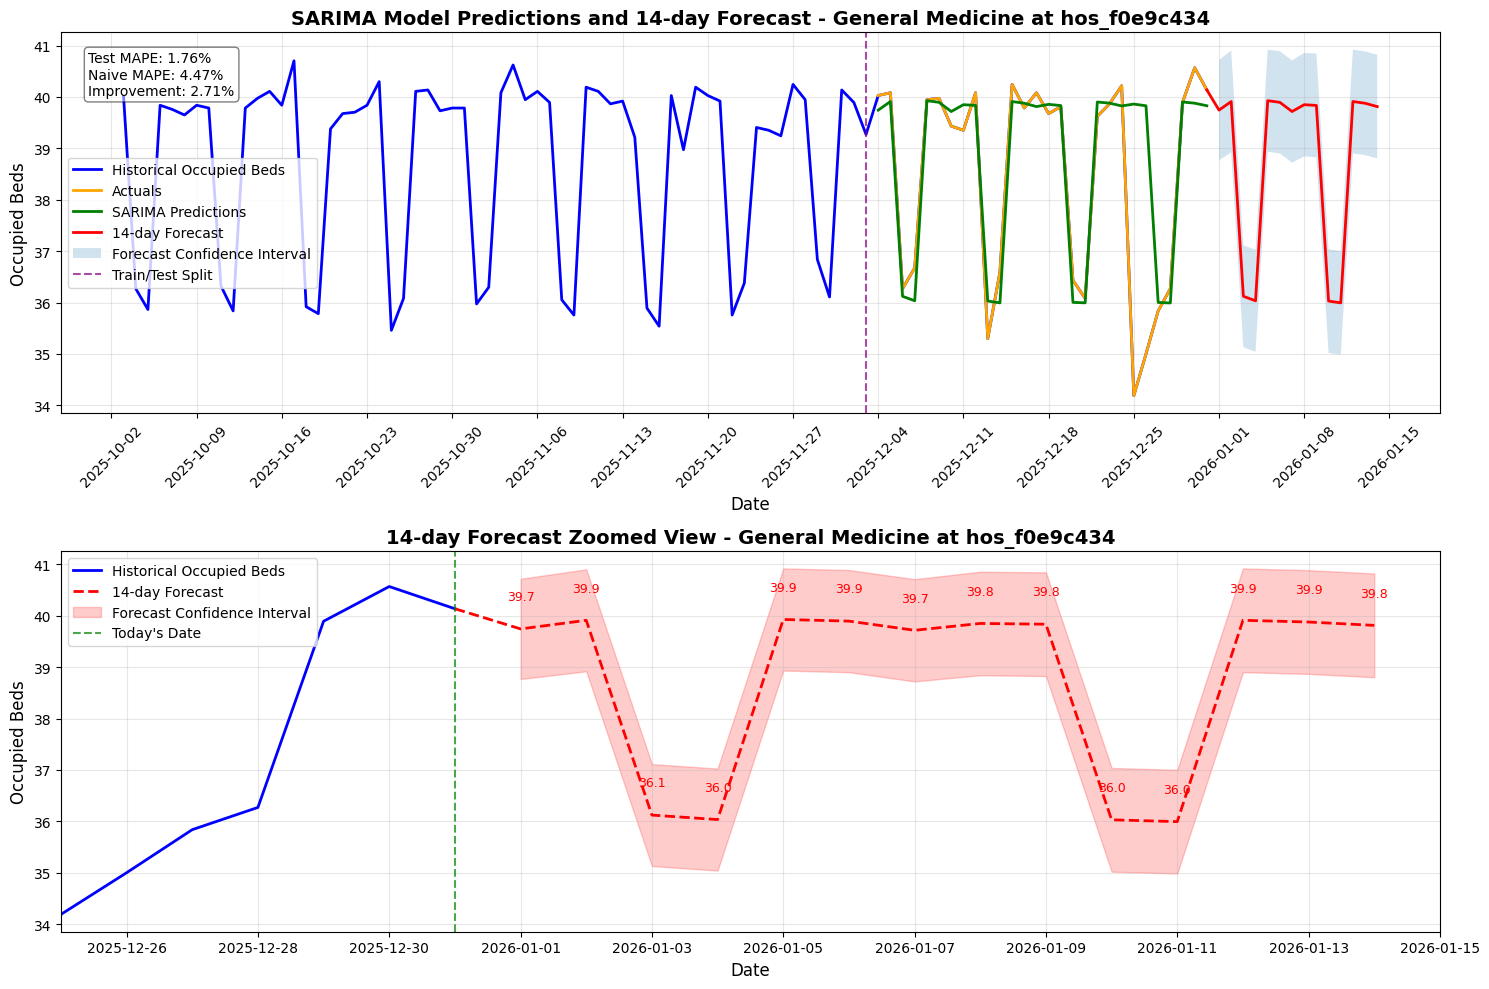

In [23]:
# prepare data for plotting
last_historical_date = ts.index.max()
last_historical_value = ts.iloc[-1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# plot 1: Historical, Predictions, and Forecast
ax1.plot(ts.index[- HISTORY_DAYS:], ts.values[-HISTORY_DAYS:], label='Historical Occupied Beds', linewidth=2, color='blue')
ax1.plot(test.index, test.values, label = 'Actuals', linewidth=2, color='orange')
ax1.plot(test.index, test_predictions.values, label='SARIMA Predictions', linewidth=2, color='green')

forecast_dates_with_last = pd.DatetimeIndex([last_historical_date]).union(forecast_df.index)
forecast_values_with_last = [last_historical_value] + list(forecast_df["predicted_occupied_beds"])
ax1.plot(forecast_dates_with_last, forecast_values_with_last, label=f'{FORECAST_DAYS}-day Forecast', linewidth=2, color='red')

ax1.fill_between(forecast_df.index,
                forecast_df['ci_lower'],
                forecast_df['ci_upper'],
                alpha=0.2, label='Forecast Confidence Interval')

ax1.axvline(x = train_cutoff, color = 'purple', linestyle = '--', alpha=0.7, label='Train/Test Split')

ax1.set_title(f'SARIMA Model Predictions and {FORECAST_DAYS}-day Forecast - {ward_name} at {hospital_id}', fontsize=14, fontweight='bold')

ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Occupied Beds', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# add metric box
metrics_text = f"Test MAPE: {results_dict['mape']:.2f}%\nNaive MAPE: {results_dict['naive_mape']:.2f}%\nImprovement: {results_dict['naive_mape'] - results_dict['mape']:.2f}%"
ax1.text(0.02, 0.95, metrics_text, 
         transform=ax1.transAxes, 
         va = 'top',
         bbox = dict(boxstyle='round', facecolor='white', alpha=0.5),
         fontsize=10,)

# format x-axis dates
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.tick_params(axis='x', rotation=45)

# plot 2: Forecast only
zoom_start = forecast_df.index.min() - pd.Timedelta(days=7)
ax2.set_xlim([zoom_start, forecast_df.index.max() + pd.Timedelta(days=1)])

# get data from zoomed period
zoom_mask = ts.index >= zoom_start
zoom_historical = ts[zoom_mask]

ax2.plot(zoom_historical.index, zoom_historical.values, 
         label='Historical Occupied Beds', linewidth=2, color='blue')

ax2.plot(forecast_dates_with_last, forecast_values_with_last, '--',
            label=f'{FORECAST_DAYS}-day Forecast', linewidth=2, color='red')

ax2.fill_between(forecast_df.index,
                forecast_df['ci_lower'],
                forecast_df['ci_upper'],
                alpha=0.2, label='Forecast Confidence Interval', color='red')

# add today's line
ax2.axvline(x=last_historical_date, color = 'green', linestyle='--', alpha=0.7, label="Today's Date")

# formatting
ax2.set_title(f'{FORECAST_DAYS}-day Forecast Zoomed View - {ward_name} at {hospital_id}', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Occupied Beds', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

# format x-axis dates
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# add forecast values as text
for i, date in enumerate(forecast_df.index): #show first 5 forecast values
    value = forecast_df.loc[date, "predicted_occupied_beds"]
    ax2.text(date, value + 0.5, f"{value:.1f}", ha='center', va='bottom', fontsize=9, color='red')

plt.tight_layout()
plt.show()


In [24]:
daily_beds = hospital_df.groupby(['ward', pd.Grouper(key='datetime', freq='D')])['occupied_beds'].sum().reset_index()

print(f"Total found{daily_beds['ward'].unique().tolist()} wards.")
print(f"Total found {len(daily_beds)} wards.")

Total found['General Medicine', 'HDU', 'ICU', 'Maternity', 'Orthopaedics', 'Surgery'] wards.
Total found 4386 wards.


In [25]:
def find_best_sarima_params(train, p_range=range(0, 3), d_range=range(0, 3), q_range=range(0, 3), seasonal_order=(1, 1, 1, 7)):
    """
    Find the best SARIMA parameters using grid search based on AIC.
    
    Parameters:
    -----------
    train : pd.Series
        Training time series data
    p_range : range
        Range of p values to test (default: 0-2)
    d_range : range
        Range of d values to test (default: 0-2)
    q_range : range
        Range of q values to test (default: 0-2)
    seasonal_order : tuple
        SARIMA seasonal order (P, D, Q, s) (default: (1, 1, 1, 7))
    
    Returns:
    --------
    tuple : (best_params, best_aic, best_model_results)
        - best_params: tuple of (p, d, q) with lowest AIC
        - best_aic: AIC value of best model
        - best_model_results: fitted SARIMAX results object
    """
    pdq = list(itertools.product(p_range, d_range, q_range))
    
    best_aic = np.inf
    best_params = None
    best_model_results = None
    
    for param in pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(
                train,
                order=param,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False, maxiter=1000)
            # print(f"SARIMA{param} - AIC:{results.aic:.2f} BIC:{results.bic:.2f} HQIC:{results.hqic:.2f}")
            
            # Track the best model based on AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_model_results = results
        except:
            continue
    
    print(f"\nBest SARIMA Parameters: {best_params}")
    print(f"Best AIC: {best_aic:.2f}")
    
    return best_params, best_aic, best_model_results

# # Call the function
# best_params, best_aic, best_model_results = find_best_sarima_params(train)

In [26]:
def generate_forecast(sarima_model, ts, ward_name, hospital_id, forecast_days=14):
    """
    Generate SARIMA forecast for a given ward and hospital.
    
    Parameters:
    -----------
    sarima_model : SARIMAX results object
        Fitted SARIMA model
    ts : pd.Series
        Complete time series data
    ward_name : str
        Name of the ward
    hospital_id : str
        Hospital identifier
    forecast_days : int
        Number of days to forecast (default: 14)
    
    Returns:
    --------
    pd.DataFrame : Forecast dataframe with predictions and confidence intervals
    """
    print(f"Generating {forecast_days}-day forecast for {ward_name} at {hospital_id}...")
    
    # Generate forecast
    forecast = sarima_model.get_forecast(steps=forecast_days)
    forecast_df = forecast.summary_frame()
    
    # Create future dates for the forecast
    forecast_dates = pd.date_range(
        start=ts.index.max() + pd.Timedelta(days=1),
        periods=forecast_days,
        freq='D'
    )
    
    forecast_df.index = forecast_dates
    
    # Add metadata
    forecast_df['ward'] = ward_name
    forecast_df['hospital'] = hospital_id
    forecast_df['date'] = forecast_df.index
    
    # Rename columns for clarity
    forecast_df = forecast_df.rename(
        columns={
            'mean': 'predicted_occupied_beds',
            'mean_ci_lower': 'ci_lower',
            'mean_ci_upper': 'ci_upper'
        }
    )

   
    
    print(f"Forecast for the next {forecast_days} days:")
    print(f"Forecast period from {forecast_df.index.min().date()} to {forecast_df.index.max().date()}")
    print(f"Forecast results:")
    print(forecast_df[['date', 'predicted_occupied_beds', 'ci_lower', 'ci_upper']].round(1))
    
    return forecast_df

# # Call the function with different hospitals/wards
# forecast_df = generate_forecast(sarima_model, ts, ward_name, hospital_id, FORECAST_DAYS)

In [38]:
def forecast_with_exog(ts, exog_train, exog_test, order, forecast_days=14):
    # fit ARIMA with exogenous variables
    model = ARIMA(ts, exog=exog_train, order=order)
    results = model.fit()

    # generate forecast
    forecast = results.get_forecast(steps=forecast_days, exog=exog_test[:forecast_days])
    forecast_df = forecast.summary_frame()
    forecast_df.index = pd.date_range(
        start=ts.index.max() + pd.Timedelta(days=1),
        periods=forecast_days,
        freq='D'
    )
    return forecast_df, results


In [ ]:
def process_single_ward(hospital_id, ward_name, df, TEST_DAYS=28, FORECAST_DAYS=14):
    print("\n")
    print("=" * 50)
    print(f"Processing ward: {ward_name} at hospital: {hospital_id}...")

    # converting the 'datetime' column to datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])

    # filtering the data for a specific hospital and ward
    hospital_df = df[(df['hospital'] == hospital_id)].copy()
    ward_df = hospital_df[(hospital_df['ward'] == ward_name)].copy()

    # sorting by datetime
    ward_df = ward_df.sort_values('datetime')
    
    ts = ward_df.set_index("datetime")["occupied_beds"]
    ts = ts.resample('D').mean().ffill().bfill()

    # splitting the data into training and testing sets
    train_cutoff = ts.index.max() - pd.Timedelta(days=TEST_DAYS)
    train = ts[ts.index <= train_cutoff]
    test = ts[ts.index > train_cutoff]
    
    best_params, best_aic, best_model_results = find_best_sarima_params(train)
    
    # fit SARIMA model
    model_results = fit_model(best_params, (1, 1, 1, 7), train)
    
    # evaluate model
    results_dict = evaluate_sarima_model(train, test, model_results)

    forecast_df = generate_forecast(model_results, ts, ward_name, hospital_id, FORECAST_DAYS)
    
    return forecast_df, results_dict

In [35]:
def process_single_ward_exog(hospital_id, ward_name, df, TEST_DAYS=28, FORECAST_DAYS=14):
    print("\n")
    print("=" * 50)
    print(f"Processing ward: {ward_name} at hospital: {hospital_id}...")

    # converting the 'datetime' column to datetime type
    df['datetime'] = pd.to_datetime(df['datetime'])

    # filtering the data for a specific hospital and ward
    hospital_df = df[(df['hospital'] == hospital_id)].copy()
    ward_df = hospital_df[(hospital_df['ward'] == ward_name)].copy()

    # sorting by datetime
    ward_df = ward_df.sort_values('datetime')
    
    ts = ward_df.set_index("datetime")["occupied_beds"]
    ts = ts.resample('D').mean().ffill().bfill()

    # exogenous variable processing
    exog = ts.shift(1).dropna()  # example exogenous variable: lagged occupied beds
    ts = ts.loc[exog.index]  # align ts with exog

    # splitting the data into training and testing sets
    train_cutoff = ts.index.max() - pd.Timedelta(days=TEST_DAYS)
    train = ts[ts.index <= train_cutoff]
    test = ts[ts.index > train_cutoff]
    
    exog_train = exog[exog.index <= train_cutoff]
    exog_test = exog[exog.index > train_cutoff]
    
    best_params, best_aic, best_model_results = find_best_sarima_params(exog_train)
    
    #fit ARIMA with exogenous variables
    arima_forecast, arima_results = forecast_with_exog(train, exog_train=exog_train, exog_test=exog_test, order=best_params)
    # evaluate model
    

    # forecast_df = generate_forecast(arima_results, ts, ward_name, hospital_id, FORECAST_DAYS)
    
    return arima_forecast, arima_results

In [39]:
arima_forcast, arima_results = process_single_ward_exog(hospital_id, ward_name, df, TEST_DAYS=28, FORECAST_DAYS=14)



Processing ward: General Medicine at hospital: hos_f0e9c434...

Best SARIMA Parameters: (0, 0, 2)
Best AIC: 3276.86


In [40]:
print(arima_forcast)

occupied_beds       mean   mean_se  mean_ci_lower  mean_ci_upper
2025-12-04     47.686637  3.192874      41.428719      53.944555
2025-12-05     48.632739  3.467666      41.836239      55.429240
2025-12-06     48.444017  3.539713      41.506307      55.381727
2025-12-07     44.305045  3.539713      37.367335      51.242754
2025-12-08     46.144588  3.539713      39.206878      53.082298
2025-12-09     46.144588  3.539713      39.206878      53.082298
2025-12-10     45.224816  3.539713      38.287106      52.162526
2025-12-11     46.144588  3.539713      39.206878      53.082298
2025-12-12     47.064360  3.539713      40.126650      54.002069
2025-12-13     49.823674  3.539713      42.885965      56.761384
2025-12-14     45.224816  3.539713      38.287106      52.162526
2025-12-15     45.224816  3.539713      38.287106      52.162526
2025-12-16     47.064360  3.539713      40.126650      54.002069
2025-12-17     46.144588  3.539713      39.206878      53.082298


In [28]:
def process_all_wards(df, hospital_id = 'hos_f0e9c434', forecast_days=14, test_days=28):
    """
    Loop through all wards in the daily_beds DataFrame, fit SARIMA models, and generate forecasts.
    """

    all_forecasts = []
    all_results = {}

    for ward in df['ward'].unique():
        forecast_df, results_dict = process_single_ward(
            hospital_id,
            ward,
            df,
            TEST_DAYS=test_days,
            FORECAST_DAYS=forecast_days
        )
        all_forecasts.append(forecast_df)
        all_results[ward] = results_dict

    return all_forecasts, all_results


In [29]:
all_forecasts, all_results = process_all_wards(df, hospital_id='hos_f0e9c434', forecast_days=FORECAST_DAYS, test_days=TEST_DAYS)



Processing ward: HDU at hospital: hos_f0e9c434...


c:\Users\mrdan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Best SARIMA Parameters: (0, 0, 1)
Best AIC: 1343.56
SARIMA Model MAE: 0.51 beds
SARIMA Model MAPE: 11.47%
Naive Baseline MAPE: 15.95%
Improvement over Naive Baseline: 4.48%
Generating 14-day forecast for HDU at hos_f0e9c434...
Forecast for the next 14 days:
Forecast period from 2026-01-01 to 2026-01-14
Forecast results:
occupied_beds       date  predicted_occupied_beds  ci_lower  ci_upper
2026-01-01    2026-01-01                      4.8       3.5       6.0
2026-01-02    2026-01-02                      4.9       3.7       6.2
2026-01-03    2026-01-03                      4.1       2.9       5.3
2026-01-04    2026-01-04                      4.1       2.8       5.3
2026-01-05    2026-01-05                      4.9       3.7       6.2
2026-01-06    2026-01-06                      5.0       3.7       6.2
2026-01-07    2026-01-07                      4.9       3.6       6.1
2026-01-08    2026-01-08                      4.8       3.6       6.1
2026-01-09    2026-01-09                      4

c:\Users\mrdan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Best SARIMA Parameters: (1, 0, 2)
Best AIC: 1837.81
SARIMA Model MAE: 0.83 beds
SARIMA Model MAPE: 7.26%
Naive Baseline MAPE: 11.71%
Improvement over Naive Baseline: 4.45%
Generating 14-day forecast for Maternity at hos_f0e9c434...
Forecast for the next 14 days:
Forecast period from 2026-01-01 to 2026-01-14
Forecast results:
occupied_beds       date  predicted_occupied_beds  ci_lower  ci_upper
2026-01-01    2026-01-01                     13.1      11.3      14.8
2026-01-02    2026-01-02                     13.0      11.3      14.8
2026-01-03    2026-01-03                     11.0       9.2      12.7
2026-01-04    2026-01-04                     10.3       8.6      12.1
2026-01-05    2026-01-05                     12.9      11.1      14.7
2026-01-06    2026-01-06                     13.1      11.3      14.9
2026-01-07    2026-01-07                     12.9      11.1      14.7
2026-01-08    2026-01-08                     13.0      11.3      14.8
2026-01-09    2026-01-09                  

c:\Users\mrdan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Best SARIMA Parameters: (0, 0, 2)
Best AIC: 1916.75
SARIMA Model MAE: 0.99 beds
SARIMA Model MAPE: 9.14%
Naive Baseline MAPE: 12.09%
Improvement over Naive Baseline: 2.95%
Generating 14-day forecast for Orthopaedics at hos_f0e9c434...
Forecast for the next 14 days:
Forecast period from 2026-01-01 to 2026-01-14
Forecast results:
occupied_beds       date  predicted_occupied_beds  ci_lower  ci_upper
2026-01-01    2026-01-01                     13.1      11.2      14.9
2026-01-02    2026-01-02                     12.9      11.0      14.8
2026-01-03    2026-01-03                     10.8       8.9      12.7
2026-01-04    2026-01-04                     10.7       8.8      12.6
2026-01-05    2026-01-05                     13.1      11.2      15.0
2026-01-06    2026-01-06                     13.0      11.1      14.9
2026-01-07    2026-01-07                     12.8      11.0      14.7
2026-01-08    2026-01-08                     13.1      11.2      15.0
2026-01-09    2026-01-09               

In [30]:
def plot_ward(ax, ward_name, forecast_df, df, metrics = None, history_days = 60, hospital_id = 'hos_f0e9c434'):

    hist = df[df["hospital"] == hospital_id].copy()
    hist  = hist[hist["ward"] == ward_name].copy()
    hist = hist[hist["datetime"] > hist["datetime"].max() - pd.Timedelta(days=history_days)]

    # ensure datetime as type
    hist["datetime"] = pd.to_datetime(hist["datetime"])
    forecast_df["date"] = pd.to_datetime(forecast_df["date"])

    # last observed point
    last_date = hist["datetime"].iloc[-1]
    last_value = hist["occupied_beds"].iloc[-1]

    # plot historical data
    ax.plot(
        hist["datetime"],
        hist["occupied_beds"],
        label="Historical Occupied Beds",
        color="blue",
        linewidth=2
    )

    # plot forecast
    ax.plot(
        [last_date] + forecast_df["date"].tolist(),
        [last_value] + forecast_df["predicted_occupied_beds"].tolist(),
        label=f'{FORECAST_DAYS}-day Forecast',
        color="red",
        linewidth=2,
    )

    # confidence interval
    ax.fill_between(
        forecast_df["date"],
        forecast_df["ci_lower"],
        forecast_df["ci_upper"],
        color="red",
        alpha=0.2,
        label="Forecast Confidence Interval"
    )

    # metrics box
    if metrics:
        ax.text(
            0.02, 0.95,
            f"MAPE: {metrics['mape']:.2f}%",
            transform=ax.transAxes,
            va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
            fontsize=10,
        )
    
    # formatting
    ax.set_title(f'Forecast for {ward_name} at {hospital_id}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Occupied Beds', fontsize=10)
    ax.legend()
    ax.grid(alpha=0.3)

    # force proper date formatting
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', rotation=45)

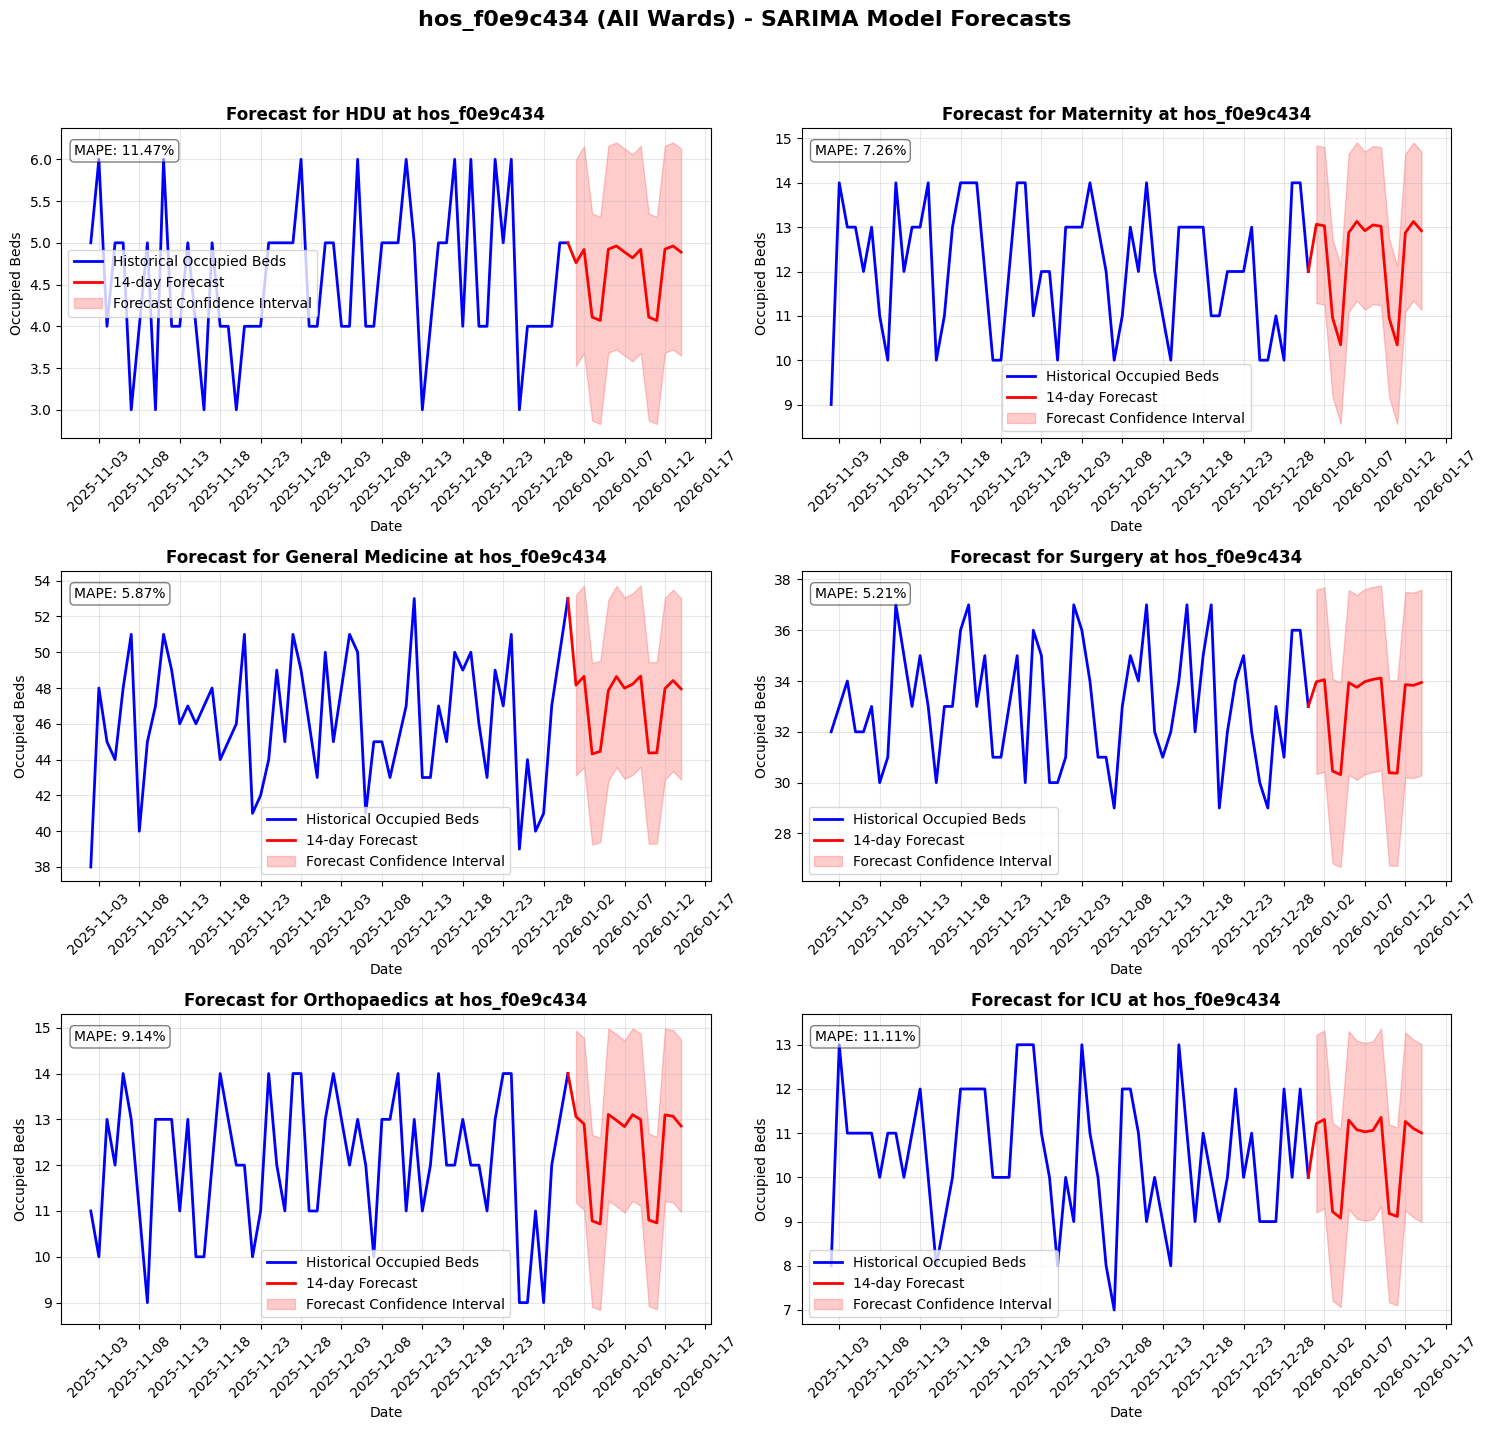

In [31]:
if all_forecasts:
    n = len(all_forecasts)
    rows = math.ceil(n / 2)

    fig, axes = plt.subplots(rows, 2, figsize=(15, rows * 5))
    axes = axes.flatten() if rows > 1 else np.array(axes)  # Handle single row case

    for i, forecast_df in enumerate(all_forecasts):
        ward = forecast_df['ward'].iloc[0]

        plot_ward(
            ax=axes[i],
            ward_name=ward,
            forecast_df=forecast_df,
            df=df,
            metrics=all_results[ward],
            history_days=60,
            hospital_id='hos_f0e9c434'
        )

    # Hide unused subplots
    for ax in axes[n:]:
        ax.set_visible(False)

    plt.suptitle(
        "hos_f0e9c434 (All Wards) - SARIMA Model Forecasts",
        fontsize=16,
        fontweight='bold'
    )

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()